# Feed-forward, CPM+log-transform

https://pmc.ncbi.nlm.nih.gov/articles/instance/10339462/bin/NIHMS1794952-supplement-supp1-3021387.pdf

https://pmc.ncbi.nlm.nih.gov/articles/PMC10339462/#SM1

In [58]:
import configparser
config = configparser.ConfigParser()
config.read("../config.ini")
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm
import random
from concurrent.futures import ThreadPoolExecutor, as_completed

from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

rna_seq_data_path = Path(config["rna"]["rna_path"])
metadata = pd.read_csv(config["rna"]["rna_metadata"])

clinical_metadata = pd.read_csv(config["clinical"]["cleaned_clinical_json"])
clinical_metadata_submitter_id = clinical_metadata["submitter_id"].values
# metadata = metadata[metadata["case_id"].isin(filter_submitter_id)] 
print(metadata.shape) # one case_id could have multiple tsv files
set(clinical_metadata_submitter_id).difference(set(metadata["case_id"].values))

(541, 8)


set()

## Preprocess

CPM + log-transform

In [8]:
metadata["case_id"].value_counts()[lambda x: x > 1]

case_id
TCGA-B2-5635    3
TCGA-B2-3923    3
TCGA-B2-3924    3
TCGA-B2-5633    3
Name: count, dtype: int64

In [ ]:
# collect cases with coressponding samples
cases = metadata["case_id"].unique()
cases_files = {case: metadata[metadata["case_id"] == case]["file_name"].values for case in cases}

def process_one_case(case_id, case_files, data_dir=rna_seq_data_path):
    """
    read files/samples for a case and
    aggregates data for that case
    """
    # initialize the dataframe
    selected_cols = ["gene_id", "log_cpm_unstranded"]
    concat_data = pd.DataFrame()
    
    # process each tsv_file for a case
    for tsv_file in case_files:
        data = pd.read_csv(data_dir / tsv_file, sep='\t', header=1)
        data = data[data["gene_type"] == "protein_coding"][["gene_id", "unstranded"]]
        # calculate CPM
        data["cpm_unstranded"] = (data["unstranded"] / data["unstranded"].sum()) * 1e6
        # calculate log-transform on CPM     
        data["log_cpm_unstranded"] = np.log1p(data["cpm_unstranded"])
        # select only gene_id and log_cpm_unstranded columns
        data = data[["gene_id", "log_cpm_unstranded"]]
        concat_data = pd.concat([concat_data, data], ignore_index=True)

    # aggregate the samples and transpose (prep for patient-gene matrix later)
    aggregated_data = concat_data.groupby("gene_id").mean().reset_index()
    aggregated_data = aggregated_data.rename(columns={selected_cols[1]: case_id})

    return aggregated_data


def process_all_cases_parallel(cases_files, max_workers=8):
    """
    outputs a case-gene matrix (like above, but in parallel)
    """
    gene_case_matrix = pd.DataFrame(columns=["gene_id"])

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_case = {executor.submit(process_one_case, case_id, case_files): case_id for case_id, case_files in cases_files.items()}
        
        for future in tqdm(as_completed(future_to_case), total=len(future_to_case)):
            case_id = future_to_case[future]
            case_data = future.result()
            if case_data is not None:
                gene_case_matrix = gene_case_matrix.merge(case_data, on="gene_id", how="outer")

    # transpose the matrix
    case_gene_matrix = gene_case_matrix.set_index("gene_id").T.reset_index().rename_axis(None, axis=1)
    case_gene_matrix.columns.values[0] = "submitter_id"
    return case_gene_matrix

case_gene_matrix = process_all_cases_parallel(cases_files)

## Model

Model configuration: 
 "Lastly, our Genomic SNN consists of 4 consecutive blocks of fully-connected layers with dimensions [64, 48, 32, 32], ELU activation, and
Alpha Dropout. For survival outcome prediction, all networks were activated using the Sigmoid function, with the output scaled
to be between -3 and 3. For grade classification, all networks were activated using the Log Softmax to compute scores for each
of the 3 WHO Grades"

Loss function: partial negative log-likelihood (cox hazard proportional)

https://pmc.ncbi.nlm.nih.gov/articles/PMC10339462/#SM1


In [6]:
def init_max_weights(module):
    for m in module.modules():
        if type(m) == nn.Linear:
            stdv = 1. / math.sqrt(m.weight.size(1))
            m.weight.data.normal_(0, stdv)
            m.bias.data.zero_()

In [ ]:
import torch
import torch.nn as nn
import numpy as np


dropout = nn.Dropout(p=0.8)  # 50% of neurons are dropped
x = torch.randn(3, 3)
output = dropout(x)
print(x)
print(output)

tensor([[-0.6515, -1.5157,  0.8950],
        [ 1.0856, -1.0960, -1.6298],
        [-0.3507, -1.4537,  1.6069]])
tensor([[-0.0000, -0.0000,  0.0000],
        [ 0.0000, -0.0000, -0.0000],
        [-0.0000, -7.2684,  8.0347]])


# Simple baseline model

- CPM+log, dim reduction, uses these features to input into a baseline linear Cox model
- CPM+log, random forest

## CPM+Log, PCA

 We empirically set the maximum number of selected features to 20 
since traditional machine learning usually suggests using one-tenth of the train sample size as 
the maximum feature number to balance dataset efficacy and overfitting.

file:///C:/Users/ASUS/Downloads/2412.07136v1.pdf



In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index

def display_km_curves(test_df, pred_risk, title_name, save_figure=False):
    fig, ax = plt.subplots(figsize=(10,8))
    kmf_high = KaplanMeierFitter()
    kmf_low = KaplanMeierFitter()
    high_risk_idx = pred_risk > np.median(pred_risk)
    low_risk_idx = pred_risk <= np.median(pred_risk)
    kmf_high.fit(test_df['time'][high_risk_idx], test_df['event'][high_risk_idx], label="High risk")
    kmf_low.fit(test_df['time'][low_risk_idx], test_df['event'][low_risk_idx], label="Low risk")
    kmf_high.plot(ax=ax, ci_show=True, show_censors=True)
    kmf_low.plot(ax=ax, ci_show=True, show_censors=True)

    ax.set_title(f"Kaplan-Meier curve for {title_name} baseline model")
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival probability")
    plt.legend()
    if save_figure:
        plt.savefig("evaluation-results/clinical-baseline.png")
    else:
        plt.show()

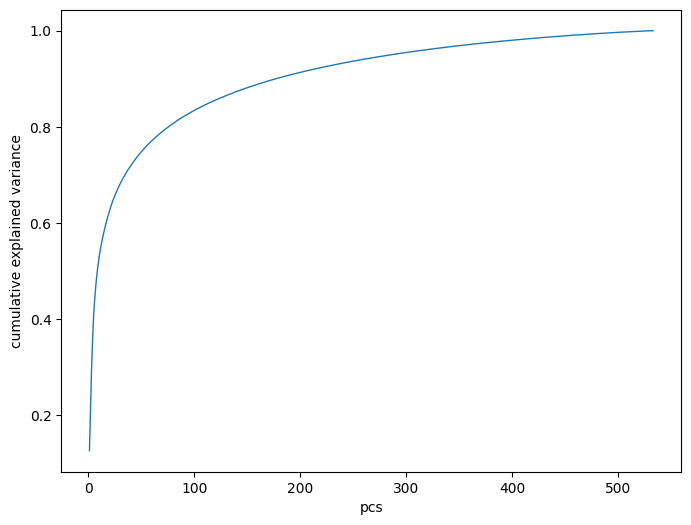

In [190]:
# this matrix is already preprocessed with CPM and log-transformed
# now, we will reduce the dimensionality simply using PCA

time_event = clinical_metadata[["time", "event", "submitter_id"]]
df_rna = pd.read_csv(config["rna"]["cleaned_rna"])

np.random.seed(0)
random.seed(0)

pca = PCA()
pca.fit(df_rna.iloc[:, 1:].values)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, linewidth=1)
plt.xlabel("pcs")
plt.ylabel("cumulative explained variance")
plt.show()

In [196]:
19962 + 13

19975

explained variance: [0.12506476 0.09030532 0.08220783 0.06161596 0.05114316 0.03140821
 0.02769713 0.02237629 0.01844675 0.01691795 0.01354707 0.0124379
 0.01136237 0.01024962 0.00984465 0.0087988 ]
training c-index: 0.7121951219512195
test c-index: 0.7326245323882654


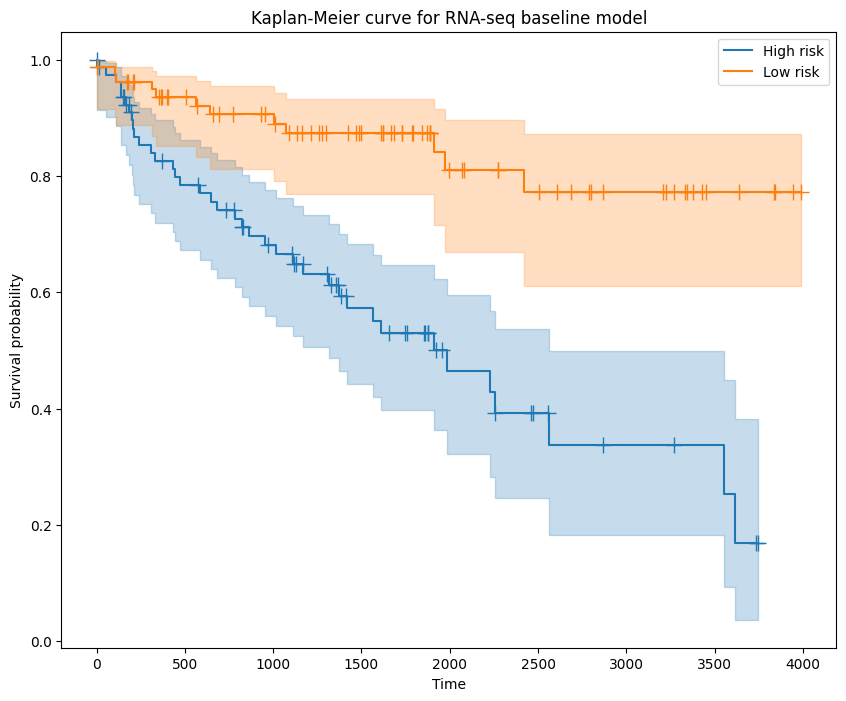

In [150]:
n_components = 16  

# fit pca on the columns not including the "submitter_id" column
pca = PCA(n_components=n_components, random_state=0) 
features_pca = pca.fit_transform(df_rna.iloc[:, 1:].values)
print("explained variance:", pca.explained_variance_ratio_)
# then convert to dataframe to merge with time and event (labels)
features_pca_df = pd.DataFrame(features_pca, columns=[f"pc{i}" for i in range(1, n_components + 1)])
# add the submitter_id back to pca 
features_pca_df["submitter_id"] = df_rna["submitter_id"].values
final_pca_data = pd.merge(features_pca_df, time_event, on="submitter_id").drop("submitter_id", axis=1)

train, test = train_test_split(final_pca_data, test_size=0.3, random_state=0)

coxph = CoxPHFitter()
coxph.fit(train, duration_col="time", event_col="event")
# the higher, the better ;; 0.5 = random, 1 = perfect
print(f"training c-index:", coxph.concordance_index_)

pred_risk = coxph.predict_partial_hazard(test.drop(["time", "event"], axis=1))
test_c_index = concordance_index(test['time'], -pred_risk, test['event'])
print("test c-index:", test_c_index)

display_km_curves(test, pred_risk, "RNA-seq", save_figure=False)

## CPM_log, random forest

Benefit: select important features/genes with interpretability

In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

# prepare inputs
full_data_rf = full_data.copy().drop("case_id", axis=1) 
predictor_columns = [col for col in full_data_rf.columns if col not in ["time", "event"]]
X = full_data_rf[predictor_columns].values

y = np.array([(bool(e), t) for e, t in zip(full_data_rf["event"], full_data_rf["time"])],
             dtype=[("event", "bool"), ("time", "float")])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

rsf = RandomSurvivalForest(random_state=123)

rsf.fit(X_train, y_train)

importances = rsf.feature_importances_

feature_importances = pd.Series(importances, index=predictor_columns)
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances.head(10)